# Clustering by SOM Learning

In [1]:
%pip install -qqq minisom

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from _defaults import (
    SEED,
    init_notebook,
    load_ballance_datasets,
    print_db_length_table,
)
import matplotlib.pyplot as plt
from minisom import MiniSom
import numpy as np
import pandas as pd

In [4]:
init_notebook()

Load (limited amount of) data.

In [5]:
data_limit = 100
_, (dataset, metadata, targets) = load_ballance_datasets(max_length=data_limit)

Load previous cached dataset from 'data/datasets-098bae95.pkl' file.


In [6]:
print_db_length_table(targets)

Dataset         Length
------------  --------
Fernverkehr        100
Güterzüge          100
Regioverkehr       100


In [7]:
som_x = 3  # math.ceil(math.sqrt(math.sqrt(len(data))))
som_y = 3
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is
# the square root of the number of series
# for the row and column counts of som
print(som_x, som_y)

3 3


### Ploting methods

In [8]:
from functools import partial

In [ ]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map, avg_fn=None):
    avg_fn = avg_fn or partial(np.average, axis=0)
    fig, axs = plt.subplots(som_x, som_y, figsize=(8 * som_x, 4 * som_y))
    fig.suptitle("Clusters")
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x, y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series, c="gray", alpha=0.5)
                axs[cluster].plot(avg_fn(np.vstack(win_map[cluster])), c="red")
            cluster_number = x * som_y + y
            axs[cluster].set_title(f"Cluster {cluster_number}")
            axs[cluster].text(
                0.99,
                1.06,
                f"{len(win_map[cluster])} sample(s)",
                ha="right",
                va="top",
                transform=axs[cluster].transAxes,
            )
    plt.show()

### MiniSom

In [10]:
som = MiniSom(som_x, som_y, len(dataset[1]), sigma=0.1, learning_rate=0.05, random_seed=SEED)
som.random_weights_init(dataset)
som.train(dataset, 50000)

In [11]:
# mapping of the winner nodes and inputs
win_map = som.win_map(dataset)

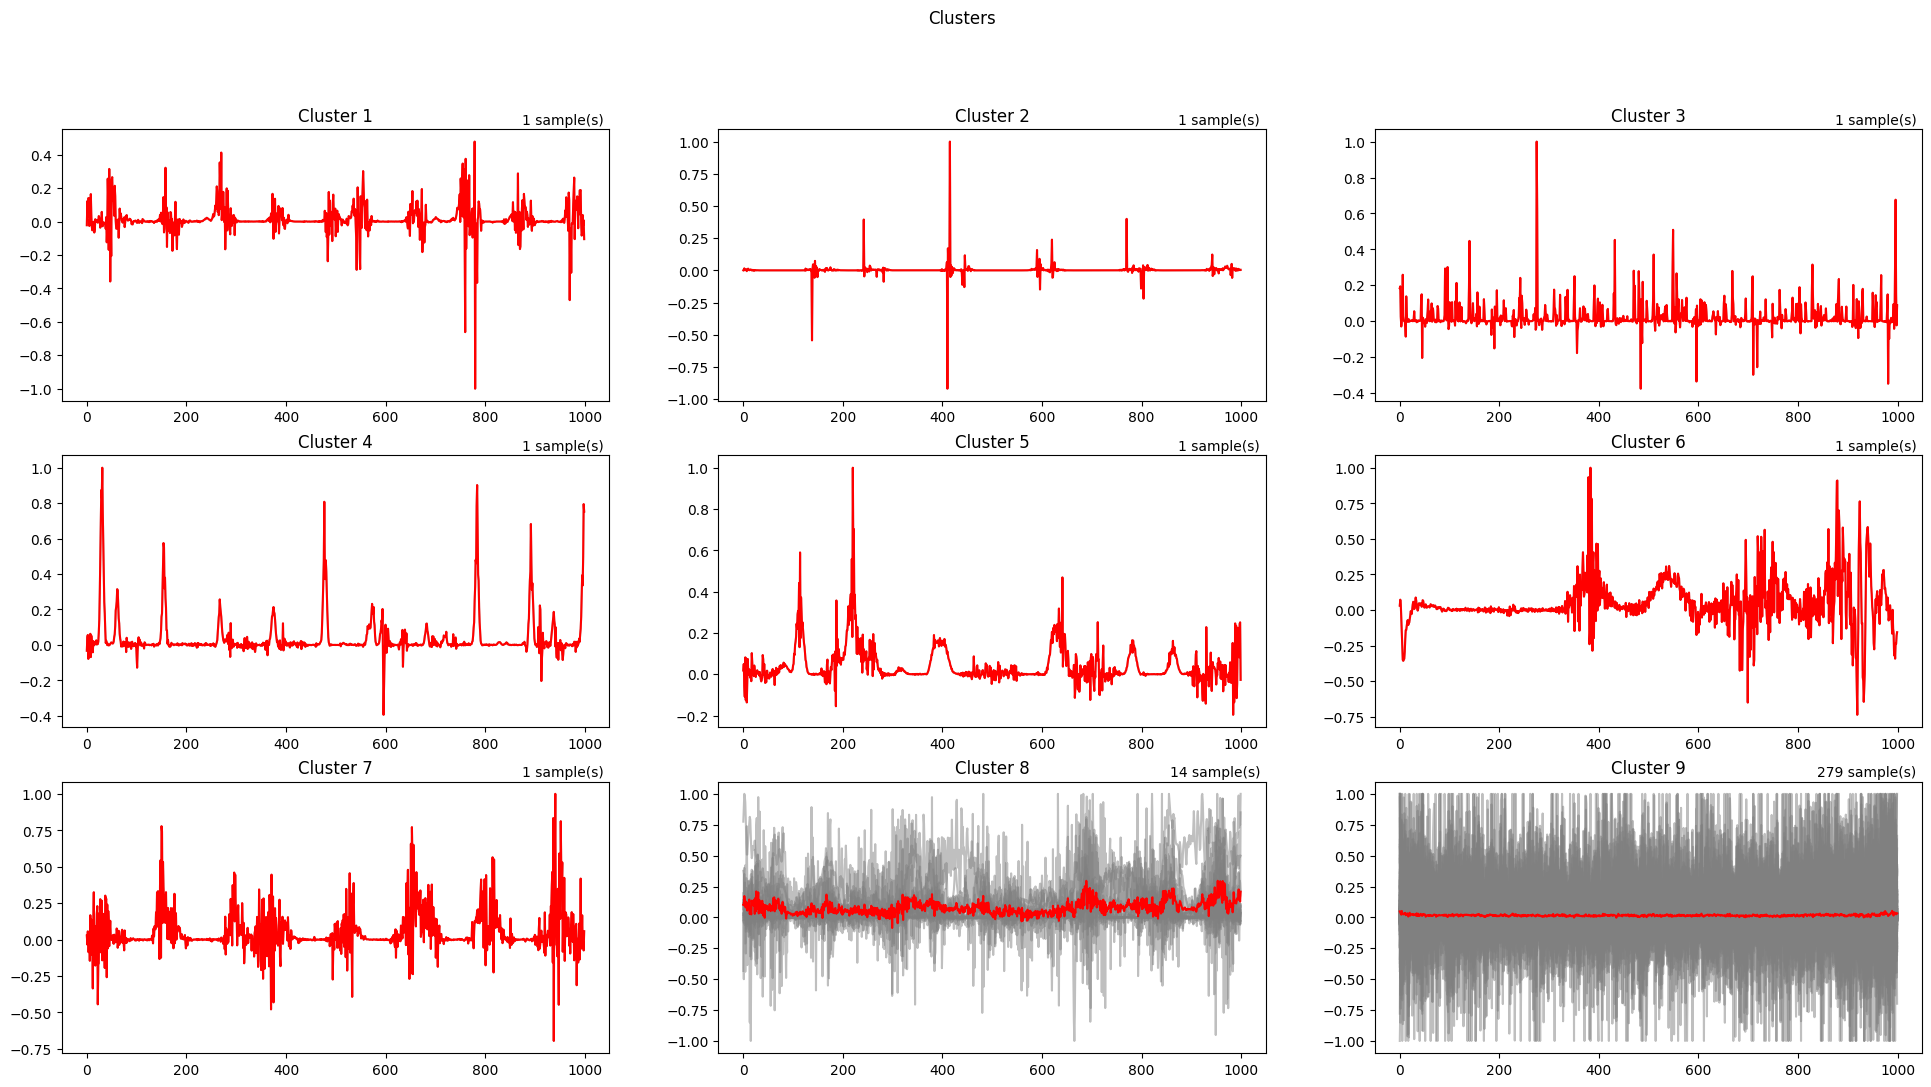

In [12]:
plot_som_series_averaged_center(som_x, som_y, win_map)

### DTW Barycenter Averaging (DBA)

In [13]:
from tslearn.barycenters import dtw_barycenter_averaging

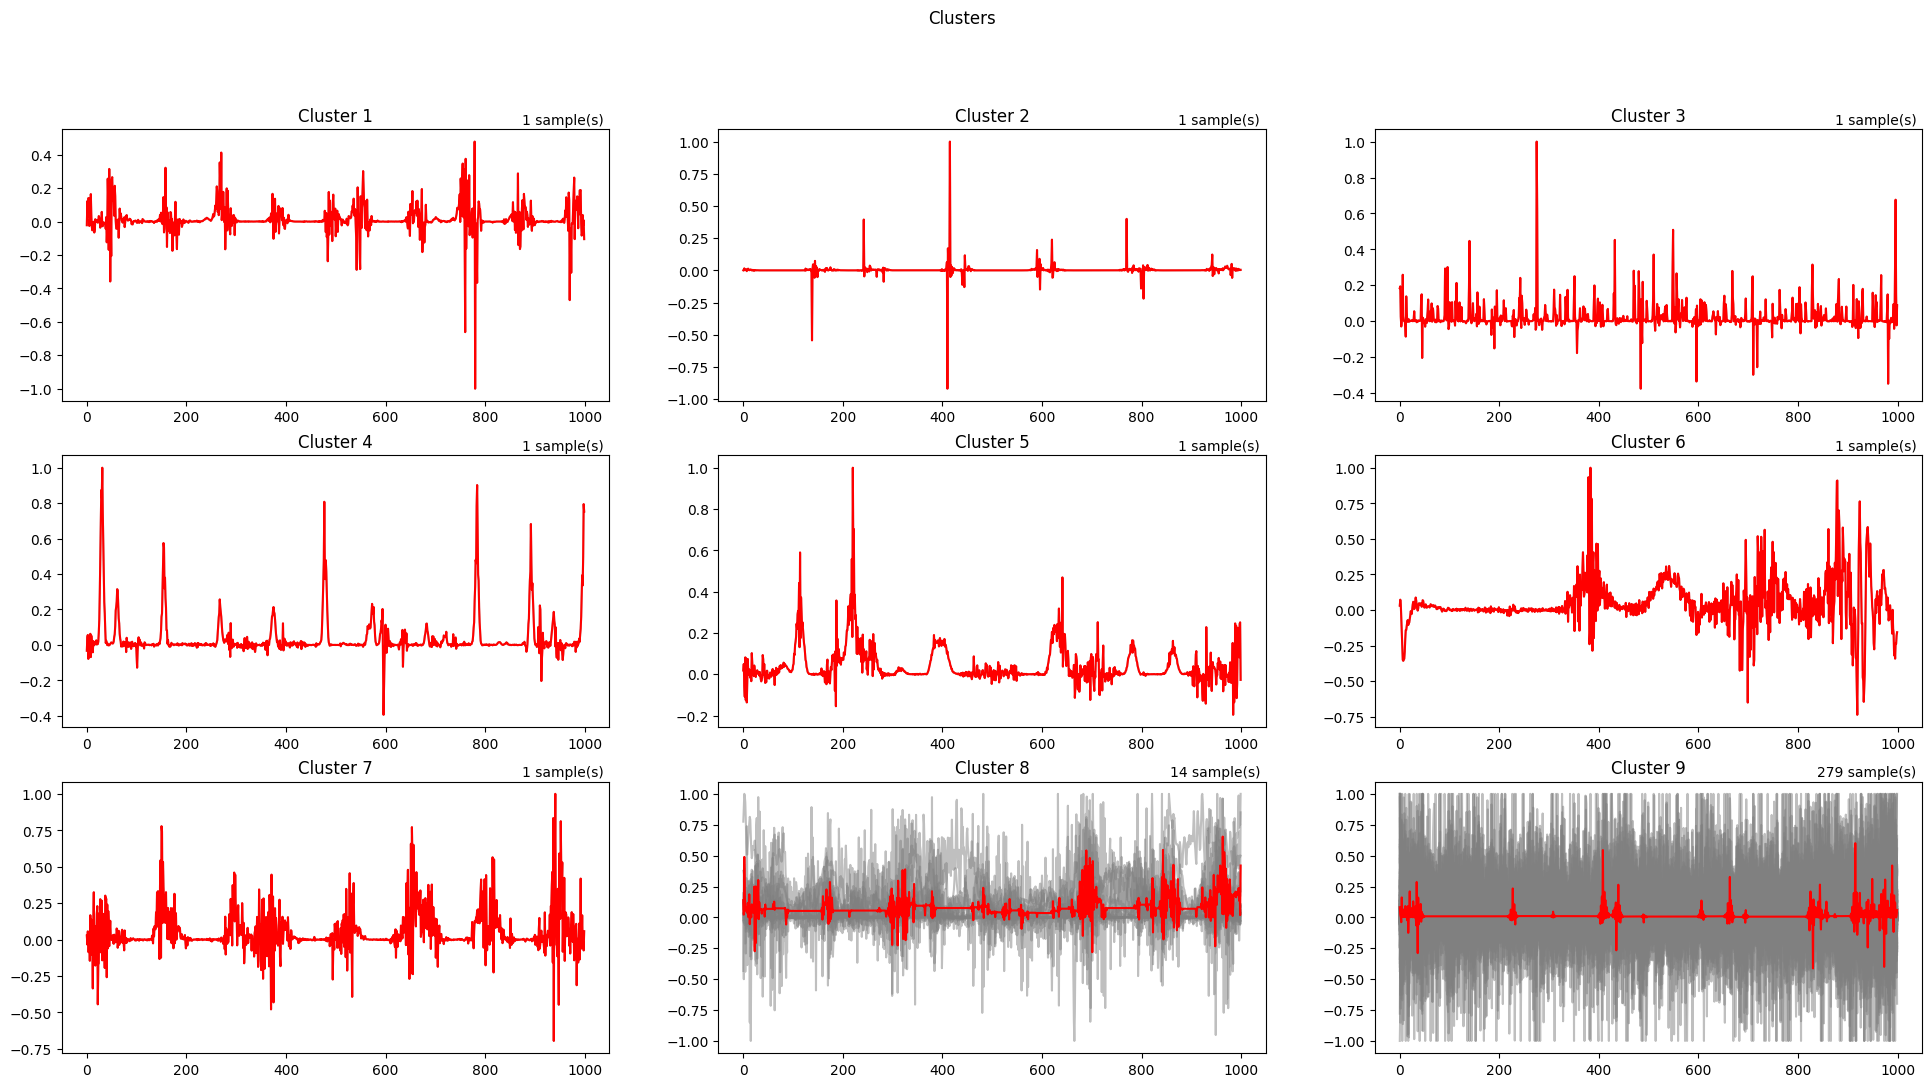

In [14]:
plot_som_series_averaged_center(som_x, som_y, win_map, dtw_barycenter_averaging)

### Cluster Distribution

In [15]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x, y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x * som_y + y + 1
        cluster_n.append(str(cluster_number))

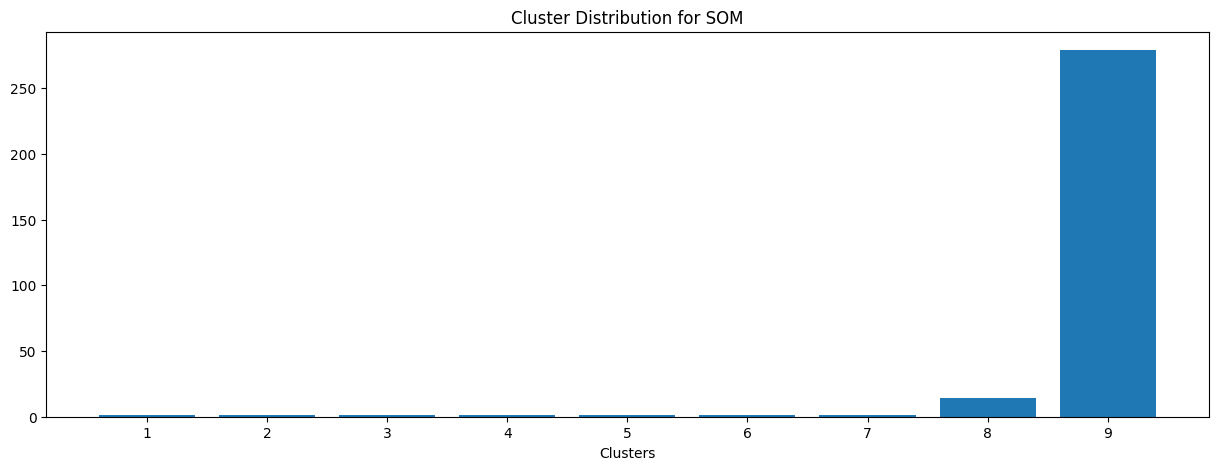

In [16]:
plt.figure(figsize=(15, 5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n, cluster_c)
plt.gca().set_xlabel("Clusters")
plt.show()

In [17]:
cluster_map = []
labels = []
for idx in range(len(dataset)):
    winner_node = som.winner(dataset[idx])
    label = winner_node[0] * som_y + winner_node[1] + 1
    labels.append(label)
    cluster_map.append((idx, f"Cluster {label}"))
pd.DataFrame(cluster_map, columns=["Series", "Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
78,Cluster 1
60,Cluster 2
120,Cluster 3
206,Cluster 4
33,Cluster 5
...,...
100,Cluster 9
99,Cluster 9
98,Cluster 9
